In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from zipfile import ZipFile
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks
import openai

In [2]:
# Suppress verbose logging
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


In [3]:
DATA_DIR = "data"
zip_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.zip')]
assert zip_files, "Place the SDNET2018 zip in `data/`."
zip_path = os.path.join(DATA_DIR, zip_files[0])
raw_dir = os.path.join(DATA_DIR, "sdnet_raw")
if not os.path.isdir(raw_dir):
    with ZipFile(zip_path, 'r') as z:
        z.extractall(raw_dir)
# Flatten nested folder if present
subdirs = [d for d in os.listdir(raw_dir) if os.path.isdir(os.path.join(raw_dir, d))]
if len(subdirs) == 1:
    raw_dir = os.path.join(raw_dir, subdirs[0])
print("Using raw data directory:", raw_dir)


Using raw data directory: data\sdnet_raw


In [4]:
# 3. Data Wrangling & Quality Checks

# Folder names in SDNET2018: 'Decks', 'Walls', 'Pavements'
structures = ['Decks', 'Walls', 'Pavements']
# Inside each: 'Cracked' and 'Non-cracked'
label_map = {'Cracked': 'crack', 'Non-cracked': 'no_crack'}


In [5]:
records = []
for struct in structures:
    for sub, lbl in label_map.items():
        folder = os.path.join(raw_dir, struct, sub)
        if os.path.isdir(folder):
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpg','.jpeg','.png')):
                    records.append({'filepath': os.path.join(folder, fname), 'label': lbl, 'structure': struct})
df = pd.DataFrame(records)
assert not df.empty, "No images found."
# Sanity checks
print(f"Total images: {len(df)}")
print(df.groupby(['structure','label']).size().unstack(fill_value=0))


Total images: 56092
label      crack  no_crack
structure                 
Decks       2025     11595
Pavements   2608     21726
Walls       3851     14287


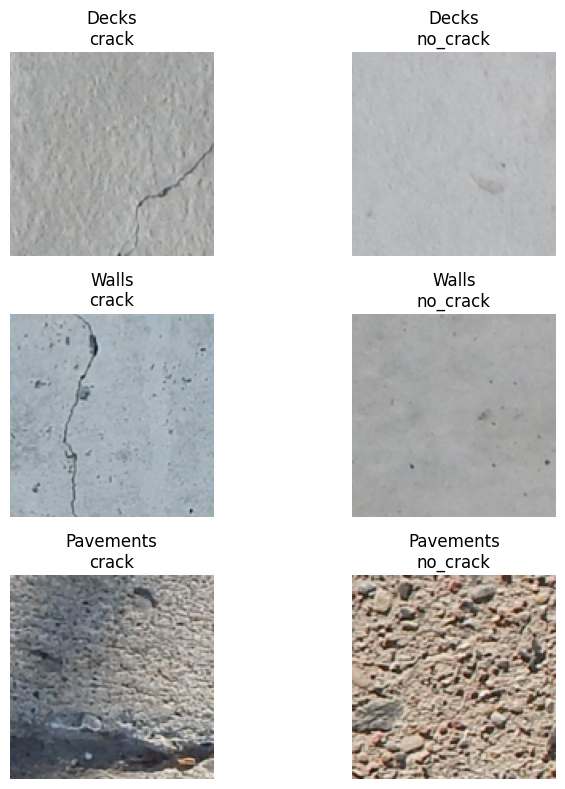

In [6]:
# Sample display: 2 images per (structure, label)
# %%
fig, axs = plt.subplots(len(structures), len(label_map), figsize=(8, 8))
for i, struct in enumerate(structures):
    for j, (sub, lbl) in enumerate(label_map.items()):
        subset = df[(df['structure']==struct)&(df['label']==lbl)]
        sample = subset['filepath'].sample(2, random_state=0).tolist()
        for k, path in enumerate(sample):
            ax = axs[i, j]
            img = Image.open(path).resize((128,128))
            ax.imshow(img)
            ax.axis('off')
        axs[i,j].set_title(f"{struct}\n{lbl}")
plt.tight_layout(); plt.show()


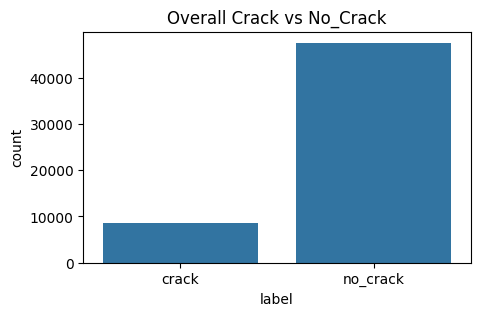

In [7]:
# 4. Exploratory Data Analysis (EDA)

# 4.1 Class distribution
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='label'); plt.title('Overall Crack vs No_Crack'); plt.show()


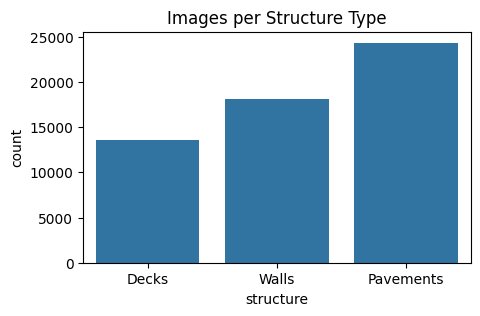

In [8]:

# 4.2 Structure distribution
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='structure'); plt.title('Images per Structure Type'); plt.show()


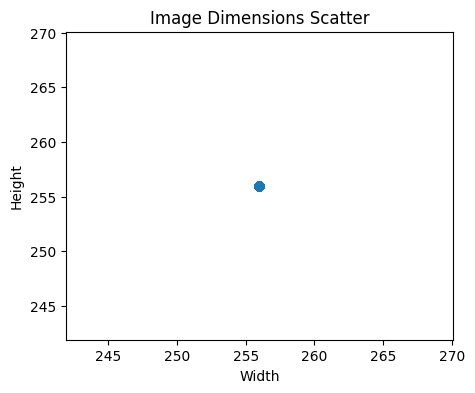

In [11]:

# 4.3 Image dimension scatter
dims = df['filepath'].apply(lambda p: Image.open(p).size)
dims = pd.DataFrame(dims.tolist(), columns=['width','height'])
plt.figure(figsize=(5,4)); plt.scatter(dims['width'], dims['height'], alpha=0.3)
plt.xlabel('Width'); plt.ylabel('Height'); plt.title('Image Dimensions Scatter'); plt.show()


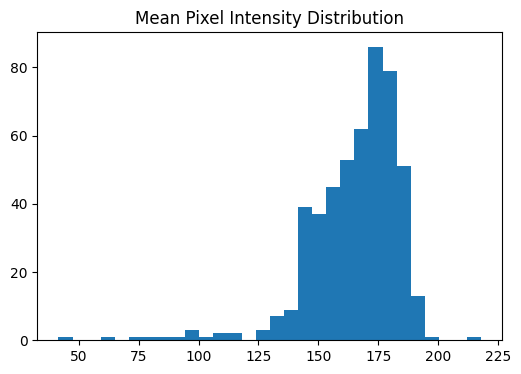

In [12]:
# 4.4 Pixel intensity histograms
plt.figure(figsize=(6,4))
int_vals = df['filepath'].sample(500, random_state=1).apply(lambda p: np.mean(np.array(Image.open(p).convert('L'))))
plt.hist(int_vals, bins=30); plt.title('Mean Pixel Intensity Distribution'); plt.show()


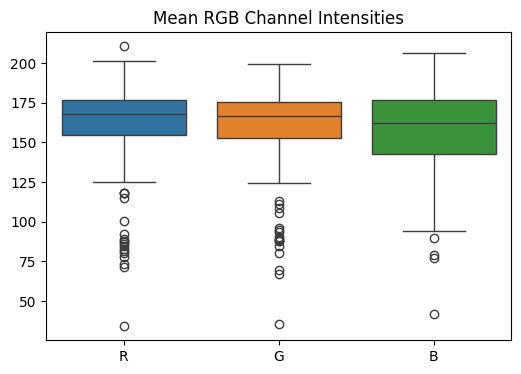

In [13]:
# 4.5 Mean RGB channel boxplots
def mean_rgb(path):
    arr = np.array(Image.open(path).resize((64,64)))
    return arr[:,:,0].mean(), arr[:,:,1].mean(), arr[:,:,2].mean()
rgb = np.array([mean_rgb(p) for p in df['filepath'].sample(300, random_state=2)])
rgb_df = pd.DataFrame(rgb, columns=['R','G','B'])
plt.figure(figsize=(6,4)); sns.boxplot(data=rgb_df); plt.title('Mean RGB Channel Intensities'); plt.show()


Available labels: ['crack' 'no_crack']


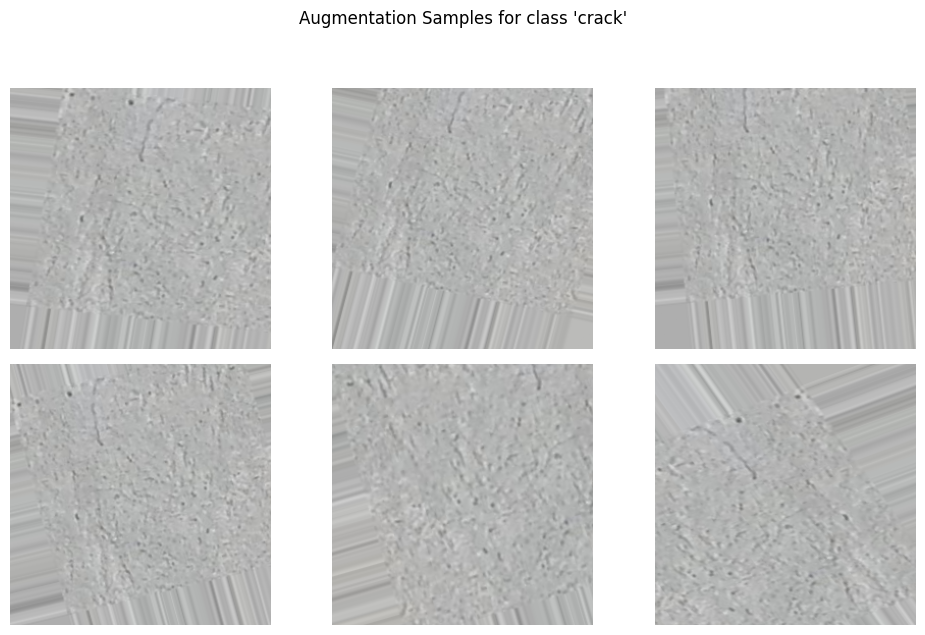

In [17]:
# 5. Data Augmentation Preview
# i) List the available class labels dynamically
labels = df['label'].unique()
print("Available labels:", labels)

# ii) Pick the first label (or change the index if you prefer another class)
example_label = labels[0]

# iii) Retrieve a sample image path for that label
sample_paths = df[df['label'] == example_label]['filepath']
if sample_paths.empty:
    raise ValueError(f"No images found for label '{example_label}'")
example_path = sample_paths.iloc[0]

# iv) Load and preprocess the image
img = Image.open(example_path).convert('RGB').resize((256, 256))
x = img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)  # shape = (1, 256, 256, 3)

# v) Define the augmentation pipeline
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# vi) Generate & plot 6 augmented samples
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, batch in enumerate(aug.flow(x, batch_size=1)):
    axes.flat[i].imshow(batch[0])
    axes.flat[i].axis('off')
    if i == 5:
        break

plt.suptitle(f"Augmentation Samples for class '{example_label}'", y=1.05)
plt.tight_layout()
plt.show()


In [18]:
# 6. Split & DataFrame-based Generators
train_df, temp_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=0.5, random_state=42)
print(f"Sizes: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
IMG_SIZE=(128,128); BATCH=64

gen_args = dict(rescale=1./255, rotation_range=20, zoom_range=0.1,
                width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_gen = ImageDataGenerator(**gen_args).flow_from_dataframe(train_df, x_col='filepath', y_col='label',
                                                               target_size=IMG_SIZE, batch_size=BATCH, class_mode='categorical')
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(val_df, x_col='filepath', y_col='label',
                                                                target_size=IMG_SIZE, batch_size=BATCH, class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(test_df, x_col='filepath', y_col='label',
                                                                 target_size=IMG_SIZE, batch_size=BATCH, class_mode='categorical', shuffle=False)


Sizes: Train=44873, Val=5609, Test=5610
Found 44873 validated image filenames belonging to 2 classes.
Found 5609 validated image filenames belonging to 2 classes.
Found 5610 validated image filenames belonging to 2 classes.


In [21]:
# 7. Performance-Optimized Model Training (MobileNetV2)
tf.keras.backend.clear_session()
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base.trainable = False
model = models.Sequential([base, layers.GlobalAveragePooling2D(), layers.Dropout(0.3), layers.Dense(2)])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Convert generators to tf.data
AUTOTUNE = tf.data.AUTOTUNE


In [22]:
def to_dataset(gen):
    # Use consistent image size and 3 channels
    height, width = IMG_SIZE
    channels = 3
    num_classes = len(gen.class_indices)
    ds = tf.data.Dataset.from_generator(
        lambda: gen,
        output_signature=(
            tf.TensorSpec(shape=(None, height, width, channels), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    )
    return ds.prefetch(AUTOTUNE)


In [23]:
dtrain = to_dataset(train_gen)
dval = to_dataset(val_gen)

# Compute known steps per epoch to display progress
steps_per_epoch = len(train_df) // BATCH
validation_steps = len(val_df) // BATCH

history = model.fit(
    dtrain,
    validation_data=dval,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 440s 619ms/step - accuracy: 0.7078 - loss: 0.7139 - val_accuracy: 0.8847 - val_loss: 0.3215
Epoch 2/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 491s 702ms/step - accuracy: 0.8682 - loss: 0.3796 - val_accuracy: 0.8945 - val_loss: 0.2880
Epoch 3/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 385s 550ms/step - accuracy: 0.8723 - loss: 0.3611 - val_accuracy: 0.8986 - val_loss: 0.2798
Epoch 4/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 344s 491ms/step - accuracy: 0.8847 - loss: 0.3342 - val_accuracy: 0.9023 - val_loss: 0.2803
Epoch 5/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 323s 461ms/step - accuracy: 0.8857 - loss: 0.3257 - val_accuracy: 0.9080 - val_loss: 0.2611
Epoch 6/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 301s 430ms/step - accuracy: 0.8919 - loss: 0.3100 - val_accuracy: 0.9051 - val_loss: 0.2761
Epoch 7/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 329s 470ms/step - accuracy: 0.8906 - loss: 0.3146 - val_accuracy: 0.9062 - val_loss: 0.2652
Epoch 8/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 338s 482ms/step - accuracy: 0.8912 -

C:\Users\manee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 86s 959ms/step


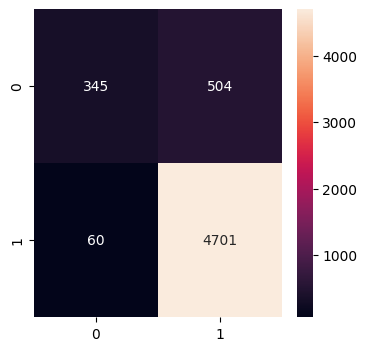

              precision    recall  f1-score   support

           0       0.85      0.41      0.55       849
           1       0.90      0.99      0.94      4761

    accuracy                           0.90      5610
   macro avg       0.88      0.70      0.75      5610
weighted avg       0.90      0.90      0.88      5610



In [24]:
# 8. Advanced Evaluation & Result Analysis
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4)); sns.heatmap(cm, annot=True, fmt='d'); plt.show()
print(classification_report(y_true, y_pred))


88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step
Test AUC = 0.85


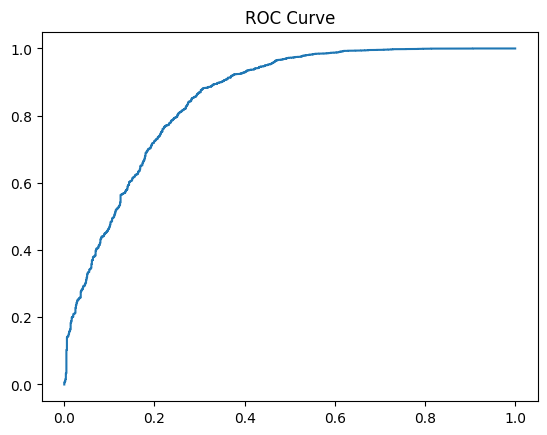

In [25]:
y_scores = tf.nn.softmax(model.predict(test_gen), axis=1)[:,1]
fpr, tpr, _ = roc_curve(y_true, y_scores)
print(f"Test AUC = {auc(fpr, tpr):.2f}")
plt.plot(fpr, tpr); plt.title('ROC Curve'); plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step


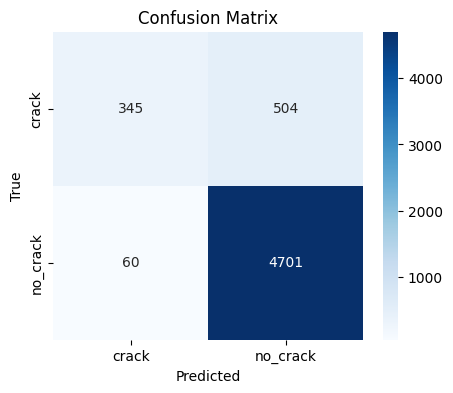

In [26]:

# 9.1 Confusion Matrix Visualization
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


In [27]:
# 9.2 Classification Report & Metrics Summary
report_dict = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("Classification Report:")
display(report_df)


Classification Report:


,precision,recall,f1-score,support
crack,0.851852,0.406360,0.550239,849.000000
no_crack,0.903170,0.987398,0.943408,4761.000000
accuracy,0.899465,0.899465,0.899465,0.899465
macro avg,0.877511,0.696879,0.746823,5610.000000
weighted avg,0.895404,0.899465,0.883907,5610.000000


In [28]:

# Save report to CSV
report_df.to_csv('classification_report.csv', index=True)
print("Saved detailed classification metrics to classification_report.csv")


Saved detailed classification metrics to classification_report.csv


88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step


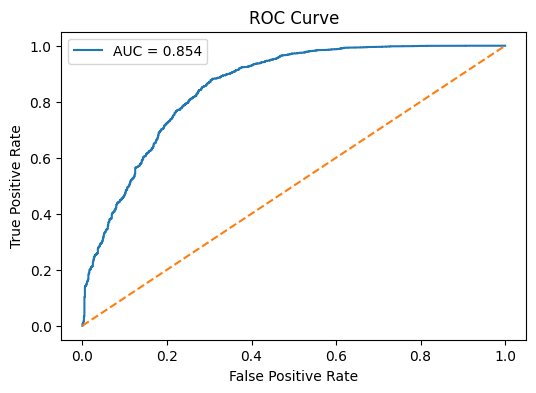

In [29]:
# 9.3 ROC Curve & AUC
y_scores = tf.nn.softmax(model.predict(test_gen), axis=1)[:,1]
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc_value = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_value:.3f}')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.show()


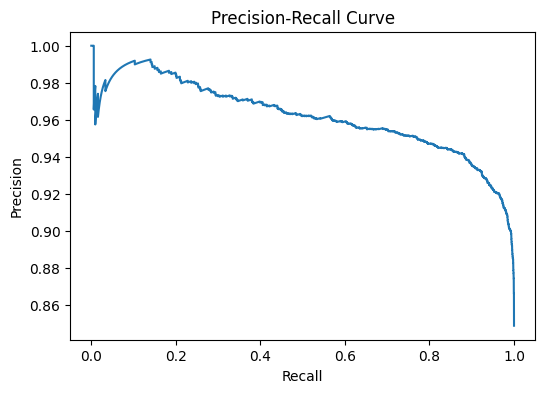

In [30]:
# 9.4 Precision-Recall Curve
dp, dr, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(6,4))
plt.plot(dr, dp)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()


Total misclassified: 564


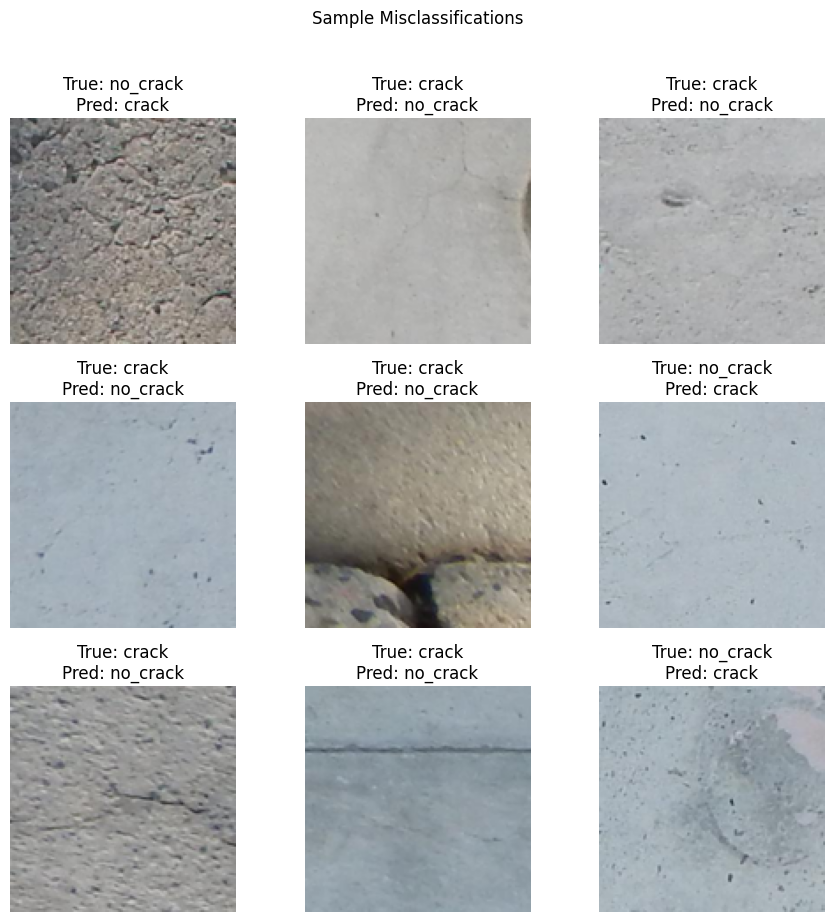

In [34]:

#  Build a lookup from numeric index → class name
idx2class = {v: k for k, v in test_gen.class_indices.items()}

# ———————————————
# 5. Find misclassified indices
# ———————————————
mis_idx = np.where(y_true != y_pred)[0]
print(f"Total misclassified: {len(mis_idx)}")

# ———————————————
# 6. Select up to 9 examples
# ———————————————
sample_idx = mis_idx[:9]

# ———————————————
# 7. Plot 3×3 grid of misclassifications
# ———————————————
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, i in zip(axes.flatten(), sample_idx):
    # get the correct image path
    if hasattr(test_gen, "filepaths"):
        img_path = test_gen.filepaths[i]
    else:
        img_path = os.path.join(test_gen.directory, test_gen.filenames[i])

    # load & show
    img = Image.open(img_path).resize((128, 128))
    ax.imshow(img)
    ax.set_title(f"True: {idx2class[y_true[i]]}\nPred: {idx2class[y_pred[i]]}")
    ax.axis("off")

for ax in axes.flatten()[len(sample_idx):]:
    ax.axis("off")

plt.suptitle("Sample Misclassifications", y=1.02)
plt.tight_layout()
plt.show()
